# ALS BL 5.3.1 Commissioning: Pilatus with Bluesky


## Overview 

__Project:__ BL531 Commissioning

__Version:__ 2025-07-02

__Contributors:__
- awojdyla@lbl.gov
- francisho@lbl.gov
- jmchen@lbl.gov
- seijdeleon@lbl.gov
- gabrielgazolla@lbl.gov

__Description:__

This notebook documents the commissioning of BL531 using the Bluesky framework to connect, configure, and operate the Pilatus detector, and access the data. 


## Set Up

### Import libraries

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Qt5Agg', force=True)    # Use Qt5Agg backend for interactive plots
import matplotlib.pyplot as plt
plt.ion()   # Enable interactive mode

import h5py
import hdf5plugin   # For compression support

from PIL import Image   # For Tif image display

from IPython.display import display # For displaying images in Jupyter

import time
from time import sleep as time_sleep

import os
from datetime import datetime

In [2]:
import epics
import bluesky
from bluesky import RunEngine

from bluesky.callbacks import LiveTable, LivePlot
from bluesky.callbacks.best_effort import BestEffortCallback

from bluesky.plans import scan, count, list_scan, grid_scan 

from databroker import Broker

RE = RunEngine({})

# Insert all metadata/data captured into db.
db = Broker.named('temp')
RE.subscribe(db.insert)

# Setup BestEffortCallback for automatic plots and tables
bec = BestEffortCallback()
RE.subscribe(bec)   # Default live feedback

1

### Connect motors and diode

In [3]:
# Connect to EPICS motors and signals

import ophyd
from ophyd import EpicsMotor, EpicsSignal

ophyd.set_cl('caproto')

mono_angle_deg = ophyd.EpicsMotor('bl531_xps1:mono_angle_deg', name='mono angle [deg]')
beamstop_diode = ophyd.EpicsSignal('bl201-beamstop:current', name='beamstop diode')
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Test connections and readbacks
mono_angle_deg.wait_for_connection(timeout=2.0)
print(mono_angle_deg.read())
beamstop_diode.wait_for_connection(timeout=2.0)
print(beamstop_diode.read())

OrderedDict([('mono angle [deg]', {'value': 25.199, 'timestamp': 1751567783.060166}), ('mono angle [deg]_user_setpoint', {'value': 25.198815452865393, 'timestamp': 1751567783.060166})])
{'beamstop diode': {'value': -155.7, 'timestamp': 1751567785.049552}}


#### Comments: Interuptions of scans

https://blueskyproject.io/bluesky/main/state-machine.html

On terminal
- __Pause Now: Ctrl+C twice__
- __Pause Soon: Ctrl+C once__

On this notebook: manually interupt (__ONLY ABLE TO PAUSE SOON__)

Results:
```
RunEngineInterrupted:
Your RunEngine is entering a paused state. These are your options for changing
the state of the RunEngine:
RE.resume()    Resume the plan.
RE.abort()     Perform cleanup, then kill plan. Mark exit_stats='aborted'.
RE.stop()      Perform cleanup, then kill plan. Mark exit_status='success'.
RE.halt()      Emergency Stop: Do not perform cleanup --- just stop.
```

To check if the scan is ‘paused’ or ‘idle’, ask: 
```
RE.state
```

### Set up mono -> energy


In [4]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
# Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
# Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg

# inverse function to go from mono angle to eV
energy_eV = lambda mono_deg_input: (h_m2kgps*c_mps*e_eV)/((2 * a_Si111_m) * np.sin((np.pi/180)*(mono_deg_input - mono_offset_deg)))

In [ ]:
# Test: print current energy

current_mono = epics.caget('bl531_xps1:mono_angle_deg')
current_energy = np.round(energy_eV(current_mono), 1)
print(f'Current energy: {current_energy} eV')

Current energy: 9200.0 eV


CA.Client.Exception...............................................
    Context: "192.168.10.123:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Mon Jul 14 2025 11:02:19.534658574
..................................................................
Server at 192.168.10.123:5064 is unresponsive. Disconnecting circuit manager <VirtualCircuitManager circuit=<VirtualCircuit host='192.168.10.123' port=5064 our_role=Role.CLIENT> logger_name='caproto.circ'> pvs=19 ioids=0 subscriptions=16>. PVs will automatically begin attempting to reconnect to a responsive server.
Server at 192.168.10.123:33783 is unresponsive. Disconnecting circuit manager <VirtualCircuitManager circuit=<VirtualCircuit host='192.168.10.123' port=33783 our_role=Role.CLIENT> logger_name='caproto.circ'> pvs=38 ioids=0 subscriptions=32>. PVs will automatically begin attempting to reconnect to a responsive server.
Server at 192.168.10.123:32915 is unresponsive. Disconnecting circuit manager <VirtualCircuitManager c

### Connect and configure Pilatus detector

In [8]:
# =============================================================================
# PILATUS DETECTOR CONFIGURATION
# =============================================================================

from ophyd import ADComponent, ImagePlugin, PilatusDetector, SingleTrigger, EpicsSignalRO
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34

# CONFIGURATION PARAMETERS
DETECTOR_PREFIX = "13PIL1:"
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Detector settings
EXPOSURE_TIME = 0.1      # seconds
ACQUIRE_PERIOD = 0.105   # seconds

# DETECTOR CLASSES
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    """Custom HDF5 plugin with file store integration"""
    pass

class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# DETECTOR INITIALIZATION

print("Initializing Pilatus detector...")

# Create detector instance
det = MyPilatusDetector(DETECTOR_PREFIX, name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = EXPOSURE_TIME
det.cam.stage_sigs["acquire_period"] = ACQUIRE_PERIOD
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]
det.hdf1.stage_sigs["capture"] = 1

print("\nPilatus detector configured successfully!")
print(f"    PV prefix: {DETECTOR_PREFIX}")
print(f"    Exposure time: {EXPOSURE_TIME}s")
print(f"    Acquire period: {ACQUIRE_PERIOD}s")

# Function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)
    
# Test connectivity and show next file
try:
    file_path_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FilePath_RBV')
    file_name_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileName_RBV')
    file_number_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileNumber_RBV')
    time.sleep(1)
    
    current_path = ascii_array_to_string(file_path_signal.get())
    current_name = ascii_array_to_string(file_name_signal.get())
    next_file_number = file_number_signal.get()
    
    # Construct next filename
    next_filename = f"{current_path}{current_name}{next_file_number:03d}.tif"

    print("\nDetector connectivity confirmed!")
    print(f"    File path: {current_path}")
    print(f"    Base name: {current_name}")
    print(f"    Next file number: {next_file_number}")
    print(f"    Next file will be: {next_filename}")
    
except Exception as e:
    print(f"⚠️  Connectivity test failed: {e}")

Initializing Pilatus detector...

Pilatus detector configured successfully!
    PV prefix: 13PIL1:
    Exposure time: 0.1s
    Acquire period: 0.105s

Detector connectivity confirmed!
    File path: /mnt/data531/
    Base name: 20250630_alien
    Next file number: 42
    Next file will be: /mnt/data531/20250630_alien042.tif


In [ ]:
# =============================================================================
# Defines LiveTable and file tracking callbacks.
# =============================================================================

from bluesky.callbacks import CallbackBase

class LiveTableWithPoint(LiveTable):
    """Enhanced LiveTable with point numbers and clean columns"""
    
    def event(self, doc):
        # Add point number as a data column
        doc = dict(doc)
        if 'data' not in doc:
            doc['data'] = {}
        doc['data'] = dict(doc['data'])
        doc['data']['point'] = doc['seq_num']
        
        # Remove setpoint columns for cleaner display
        keys_to_remove = [key for key in doc['data'].keys() if 'user_setpoint' in key]
        for key in keys_to_remove:
            del doc['data'][key]
        
        super().event(doc)

class FilePathCallback(CallbackBase):
    """Tracks file paths and provides scan summary"""
    
    def __init__(self):
        self.scan_data = []
        
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        self.scan_data = []
        
    def event(self, doc):
        try:
            point_num = doc['seq_num']
            x_pos = doc['data'].get('sample stage horizontal', 0)
            y_pos = doc['data'].get('sample stage vertical', 0)
            
            # Get file information
            file_number_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileNumber_RBV')
            file_path_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FilePath_RBV')
            file_name_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileName_RBV')
            
            current_file_num = file_number_signal.get() - 1
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
            self.scan_data.append({
                'point': point_num,
                'x_pos': x_pos,
                'y_pos': y_pos,
                'full_path': full_path
            })
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Error - {e}")
            self.scan_data.append({
                'point': doc['seq_num'],
                'x_pos': doc['data'].get('sample stage horizontal', 0),
                'y_pos': doc['data'].get('sample stage vertical', 0),
                'full_path': f"Error: {e}"
            })
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")
        self.print_scan_summary()
    
    def print_scan_summary(self):
        print("\n" + "="*100)
        print("📋 SCAN SUMMARY")
        print("="*100)
        print(f"{'Point':<8} {'X Position':<12} {'Y Position':<12} {'Full File Path':<60}")
        print("-" * 100)
        
        for data in self.scan_data:
            print(f"{data['point']:<8} "
                  f"{data['x_pos']:<12.3f} "
                  f"{data['y_pos']:<12.3f} "
                  f"{data['full_path']:<60}")
        
        print("-" * 100)
        print(f"Total points: {len(self.scan_data)}")
        print("="*100)

print("✅ Scan classes ready!")

✅ Scan classes ready!


### Defined custom functions 

## Sample stage scan, with beamstop diode

In [8]:
# Test the motors are working

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 6, sample_y_mm, 0, 20, 6, snake_axes = True))

('af523257-6c93-41fa-bbf6-bde3f2cbd87d',)

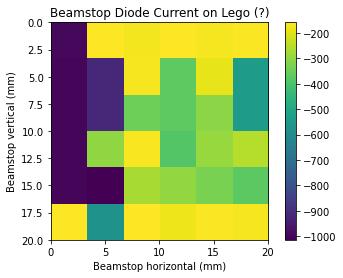

In [11]:
# Plot the results
%matplotlib inline

header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(6, 6)

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

In [12]:
# Finer scan

RE(grid_scan([beamstop_diode], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20, 21, snake_axes = False))

('8aeef522-5681-4bc2-b4ec-b95b238cba51',)

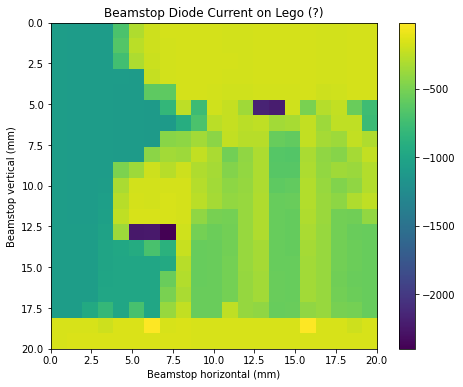

In [13]:
# Plot the results

header = db[-1]
a = header.table()

h = a['sample stage horizontal'].to_numpy()
v = a['sample stage vertical'].to_numpy()
b = a['beamstop diode'].to_numpy()
b = b.reshape(21, 21)

plt.figure(figsize=(8,6))

plt.imshow(b.T, extent=(h.min(), h.max(), v.max(), v.min()), aspect='equal')     # transpose to get the right orientation
plt.xlabel('Beamstop horizontal (mm)')
plt.ylabel('Beamstop vertical (mm)')
plt.title('Beamstop Diode Current on Lego (?)')
plt.colorbar()
plt.show()

In [6]:
RE(scan([beamstop_diode], sample_x_mm, 0, 6, 4))



Transient Scan ID: 1     Time: 2025-07-02 17:34:17
Persistent Unique Scan ID: '1cf05113-e677-481e-a141-8d381ab30682'
New stream: 'primary'
+-----------+------------+-------------------------+----------------+
|   seq_num |       time | sample stage horizontal | beamstop diode |
+-----------+------------+-------------------------+----------------+
|         1 | 17:34:28.9 |                  0.0000 |          -1135 |
|         2 | 17:34:32.0 |                  2.0000 |          -1136 |
|         3 | 17:34:35.0 |                  4.0000 |           -767 |
|         4 | 17:34:38.1 |                  6.0000 |           -149 |
+-----------+------------+-------------------------+----------------+
generator scan ['1cf05113'] (scan num: 1)





('1cf05113-e677-481e-a141-8d381ab30682',)

In [7]:
RE(grid_scan([beamstop_diode], sample_x_mm, 6, 10, 3, sample_y_mm, 6, 10, 3, snake_axes = True))



Transient Scan ID: 2     Time: 2025-07-02 17:34:45
Persistent Unique Scan ID: 'd6dfa9ee-5ea8-4abb-b0d3-4f58e34ee58c'
New stream: 'primary'
+-----------+------------+-------------------------+-----------------------+----------------+
|   seq_num |       time | sample stage horizontal | sample stage vertical | beamstop diode |
+-----------+------------+-------------------------+-----------------------+----------------+
|         1 | 17:34:50.7 |                  6.0000 |                6.0000 |           -824 |
|         2 | 17:34:53.7 |                  6.0000 |                8.0000 |           -928 |
|         3 | 17:34:56.8 |                  6.0000 |               10.0000 |            -20 |
|         4 | 17:34:59.9 |                  8.0000 |               10.0000 |           -168 |
|         5 | 17:35:03.0 |                  8.0000 |                8.0000 |           -173 |
|         6 | 17:35:06.1 |                  8.0000 |                6.0000 |           -458 |
|         7 |

('d6dfa9ee-5ea8-4abb-b0d3-4f58e34ee58c',)

In [8]:
RE(scan([beamstop_diode], sample_x_mm, 6, 12, 4))



Transient Scan ID: 3     Time: 2025-07-02 17:35:40
Persistent Unique Scan ID: 'e7b7a988-f881-4a9b-97bb-876d8fc21e71'
New stream: 'primary'
+-----------+------------+-------------------------+----------------+
|   seq_num |       time | sample stage horizontal | beamstop diode |
+-----------+------------+-------------------------+----------------+
|         1 | 17:35:45.2 |                  6.0000 |           -318 |
|         2 | 17:35:48.3 |                  8.0000 |           -290 |
|         3 | 17:35:51.4 |                 10.0000 |           -275 |
|         4 | 17:35:54.5 |                 12.0000 |           -350 |
+-----------+------------+-------------------------+----------------+
generator scan ['e7b7a988'] (scan num: 3)





('e7b7a988-f881-4a9b-97bb-876d8fc21e71',)

## Sample stage scan, with Pilatus detector

### Previous codes



#### Solution 1: .TIF

In [15]:
import ophyd
from bluesky.callbacks import CallbackBase
import glob
import os
from datetime import datetime
import threading
import time

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

class OrderedLiveTable(CallbackBase):
    def __init__(self):
        self.monitoring = False
        self.start_time = None
        self.scan_points = []
        self.files_before_scan = set()
        self.displayed_points = set()  # Track which points we've already displayed
        
    def start(self, doc):
        # Capture files that exist BEFORE scan starts
        self.files_before_scan = set(glob.glob("/mnt/data531/*alien*.tif"))
        
        self.start_time = datetime.now()
        self.monitoring = True
        self.scan_points = []
        self.displayed_points = set()
        
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'Full Path':<50}")
        print("-" * 90)
        threading.Thread(target=self._watch, daemon=True).start()
    
    def event(self, doc):
        """Store each scan point as it happens"""
        point_info = {
            'point_num': doc['seq_num'],
            'x_pos': doc['data'].get('sample stage horizontal', 0),
            'y_pos': doc['data'].get('sample stage vertical', 0),
            'event_time': time.time(),
            'file_matched': False,
            'file_path': None
        }
        self.scan_points.append(point_info)
    
    def _watch(self):
        """Monitor and display files as they're detected"""
        while self.monitoring:
            try:
                # Get all current scan files
                current_files = set(glob.glob("/mnt/data531/*alien*.tif"))
                scan_files = sorted(current_files - self.files_before_scan)
                
                # Check if we have new files to display
                for i, file_path in enumerate(scan_files):
                    point_index = i  # File index matches point index
                    
                    if (point_index < len(self.scan_points) and 
                        point_index not in self.displayed_points):
                        
                        # Match file to corresponding scan point
                        point = self.scan_points[point_index]
                        point['file_matched'] = True
                        point['file_path'] = file_path
                        
                        # Display immediately
                        current_time = datetime.now().strftime('%H:%M:%S')
                        print(f"{point['point_num']:<6} "
                              f"{point['x_pos']:<8.3f} "
                              f"{point['y_pos']:<8.3f} "
                              f"{current_time:<10} "
                              f"{file_path:<50}")
                        
                        self.displayed_points.add(point_index)
                        
                time.sleep(0.1)
                
            except Exception as e:
                continue
    
    def stop(self, doc):
        """Final cleanup and ensure all files are matched"""
        print(f"\nScan finished, doing final file matching...")
        
        time.sleep(2)  # Wait for any final files
        
        # Get final list of all scan files
        final_files = set(glob.glob("/mnt/data531/*alien*.tif"))
        scan_files = sorted(final_files - self.files_before_scan)
        
        print(f"DEBUG: Files before scan: {len(self.files_before_scan)}")
        print(f"DEBUG: Files after scan: {len(final_files)}")
        print(f"DEBUG: New files during scan: {len(scan_files)}")
        
        # Match remaining files to points that weren't displayed live
        for i, file_path in enumerate(scan_files):
            if i < len(self.scan_points):
                point = self.scan_points[i]
                point['file_matched'] = True
                point['file_path'] = file_path
                
                # Display any points that weren't shown live
                if i not in self.displayed_points:
                    current_time = datetime.now().strftime('%H:%M:%S')
                    print(f"{point['point_num']:<6} "
                          f"{point['x_pos']:<8.3f} "
                          f"{point['y_pos']:<8.3f} "
                          f"{current_time:<10} "
                          f"{file_path:<50}")
        
        self.monitoring = False
        
        print("-" * 90)
        print(f"Scan completed: {len(self.scan_points)} points, {len(scan_files)} files")
        
        # Show final summary with correct file-to-point mapping
        print(f"\nFinal Summary (Correct File-to-Point Mapping):")
        for i, point in enumerate(self.scan_points):
            if i < len(scan_files):
                file_name = os.path.basename(scan_files[i])
                print(f"  Point {point['point_num']}: X={point['x_pos']:.3f}mm, Y={point['y_pos']:.3f}mm -> {file_name}")
            else:
                print(f"  Point {point['point_num']}: X={point['x_pos']:.3f}mm, Y={point['y_pos']:.3f}mm -> NO FILE FOUND")
        
        # Show chronological file list
        print(f"\nFiles created during scan (chronological order):")
        for i, file_path in enumerate(scan_files, 1):
            print(f"  {i}: {os.path.basename(file_path)}")
        
        print("-" * 90)

# Create the live table and run the scan
ordered_table = OrderedLiveTable()

# Running a scan with the pilatus detector using your defined motors
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), ordered_table)


Point  X_mm     Y_mm     Time       Full Path                                         
------------------------------------------------------------------------------------------
1      0.000    0.000    11:42:47   /mnt/data531/20250626_alien658.tif                
2      0.000    2.000    11:42:50   /mnt/data531/20250626_alien659.tif                
3      2.000    0.000    11:42:53   /mnt/data531/20250626_alien660.tif                

Scan finished, doing final file matching...
4      2.000    2.000    11:42:57   /mnt/data531/20250626_alien661.tif                
DEBUG: Files before scan: 632
DEBUG: Files after scan: 636
DEBUG: New files during scan: 4
------------------------------------------------------------------------------------------
Scan completed: 4 points, 4 files

Final Summary (Correct File-to-Point Mapping):
  Point 1: X=0.000mm, Y=0.000mm -> 20250626_alien658.tif
  Point 2: X=0.000mm, Y=2.000mm -> 20250626_alien659.tif
  Point 3: X=2.000mm, Y=0.000mm -> 20250626_alien6

('d1954aab-42a9-4364-aa65-16c880388021',)

#### Solution 2: .H5

In [ ]:
import ophyd
from bluesky.callbacks import CallbackBase
from datetime import datetime

# Motor definitions for sample positioning
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

class DetectorLiveTable(CallbackBase):
    """Live table showing scan progress with motor positions, filename displayed at end"""
    
    def __init__(self, detector):
        self.detector = detector
        self.scan_points = []
        self.filename = None
        
    def start(self, doc):
        """Initialize scan and print table header"""
        self.scan_points = []
        self.filename = None
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10}")
        print("-" * 40)
    
    def event(self, doc):
        """Process each scan point and display live results"""
        point_num = doc['seq_num']
        x_pos = doc['data'].get('sample stage horizontal', 0)
        y_pos = doc['data'].get('sample stage vertical', 0)
        
        # Get filename from detector IOC (only once since it's the same file)
        if not self.filename:
            try:
                # Method 1: Get full filename from HDF5 plugin
                if hasattr(self.detector, 'hdf1') and hasattr(self.detector.hdf1, 'full_file_name'):
                    self.filename = self.detector.hdf1.full_file_name.get()
                
                # Method 2: Construct filename from HDF5 components
                elif hasattr(self.detector, 'hdf1'):
                    try:
                        file_path = self.detector.hdf1.file_path.get()
                        file_name = self.detector.hdf1.file_name.get()
                        file_number = self.detector.hdf1.file_number.get()
                        template = self.detector.hdf1.file_template.get()
                        
                        if template and file_name:
                            self.filename = template % (file_path, file_name, file_number)
                        else:
                            self.filename = f"{file_path}/{file_name}_{file_number:03d}.h5"
                    except:
                        pass
                
                # Fallback: Generate generic filename
                if not self.filename:
                    self.filename = f"scan_data.h5"
                    
            except Exception as e:
                print(f"Error getting filename: {e}")
                self.filename = "unknown_file.h5"
        
        # Store scan point data
        point_info = {
            'point_num': point_num,
            'x_pos': x_pos,
            'y_pos': y_pos,
            'frame_num': point_num - 1  # HDF5 frames are 0-indexed
        }
        self.scan_points.append(point_info)
        
        # Display live motor positions only
        current_time = datetime.now().strftime('%H:%M:%S')
        print(f"{point_num:<6} {x_pos:<8.3f} {y_pos:<8.3f} {current_time:<10}")
    
    def stop(self, doc):
        """Display scan completion summary with scan description"""
        print("-" * 40)
        print(f"Scan completed: {len(self.scan_points)} points")
        
        # Display scan description and file info
        if self.filename and self.scan_points:
            print(f"\nHDF5 File: {self.filename}")
            
            # Calculate scan parameters
            x_positions = [p['x_pos'] for p in self.scan_points]
            y_positions = [p['y_pos'] for p in self.scan_points]
            x_range = f"{min(x_positions):.1f} to {max(x_positions):.1f} mm"
            y_range = f"{min(y_positions):.1f} to {max(y_positions):.1f} mm"
            
            print(f"Scan type: {len(self.scan_points)}-point grid scan")
            print(f"X range: {x_range}")
            print(f"Y range: {y_range}")
            print(f"Contains {len(self.scan_points)} detector frames (one per scan point)")
            
            # Save file path as global variable for data analysis
            global last_scan_file, last_scan_data
            last_scan_file = self.filename
            last_scan_data = self.scan_points.copy()
            
            print(f"\n📁 File path saved as: 'last_scan_file'")
            print(f"📊 Scan data saved as: 'last_scan_data'")
        
        print("-" * 40)

# Create live table instance
detector_table = DetectorLiveTable(det)

# Run grid scan with live monitoring
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), detector_table)

### Pilatus scans (Run from here)

Run codes from here, after the Set Up section. 

In [ ]:
detector_table = DetectorLiveTable(det) 

RE(count([det]), detector_table)


🔬 SCAN STARTED at 11:28:30
Point  X_mm     Y_mm     Time       Status    
------------------------------------------------------------
1      0.000    0.000    11:28:37   Active    
----------------------------------------
✅ SCAN COMPLETED in 7.1s
   Total points: 1

📁 HDF5 File: /mnt/data531/test/pilatus/2025/06/30/pilatus_scan_20250630_112837.h5
   Size: File not found

💾 Variables saved for analysis:
   📁 last_scan_file → pilatus_scan_20250630_112837.h5
   📊 last_scan_data → 1 scan points
   ⚙️ last_scan_config → detector settings


('90586bad-d8c2-4923-96ab-2efe4c12d900',)

In [ ]:
# Create live table instance
detector_table = DetectorLiveTable(det)

RE(grid_scan([det], sample_x_mm, 0, 1, 2, sample_y_mm, 0, 1, 2, snake_axes = True), detector_table)

In [ ]:
# Load the HDF5 data
with h5py.File(last_scan_file, 'r') as f:
    # Load all the image data
    images = f['entry/data/data'][:]
    
print(f"📊 Loaded data from: {last_scan_file}")
print(f"   Shape: {images.shape}")

In [ ]:
# Get unique motor positions
x_positions = [point['x_pos'] for point in last_scan_data]
y_positions = [point['y_pos'] for point in last_scan_data]

unique_x = sorted(list(set(x_positions)))
unique_y = sorted(list(set(y_positions)))

num_x = len(unique_x)
num_y = len(unique_y)

# Create subplot grid
fig, axes = plt.subplots(num_y, num_x, figsize=(3*num_x, 3*num_y))

# Handle single row/column cases
if num_x == 1 and num_y == 1:
    axes = [[axes]]
elif num_x == 1:
    axes = [[ax] for ax in axes]
elif num_y == 1:
    axes = [axes]

# Plot each image in correct grid position
for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    
    frame = images[i]
    
    im = axes[y_idx][x_idx].imshow(frame, cmap='viridis',
                                   vmin=np.percentile(frame, 2),
                                   vmax=np.percentile(frame, 98))
    
    axes[y_idx][x_idx].set_title(f'X={point["x_pos"]:.1f}, Y={point["y_pos"]:.1f}', fontsize=10)
    axes[y_idx][x_idx].axis('off')
    
    plt.colorbar(im, ax=axes[y_idx][x_idx], shrink=0.6)

# Add main title
plt.suptitle(f'Motor Scan Grid: {num_x}×{num_y} positions\n{last_scan_file.split("/")[-1]}', 
             fontsize=12, y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
RE(grid_scan([det], sample_x_mm, 0, 20, 21, sample_y_mm, 0, 20, 21, snake_axes = True), detector_table)
# To save time I am doing snake scan

In [ ]:
# Load the HDF5 data
with h5py.File(last_scan_file, 'r') as f:
    # Load all the image data
    images = f['entry/data/data'][:]
    
print(f"📊 Loaded data from: {last_scan_file}")
print(f"   Shape: {images.shape}")

In [ ]:
# Plot data
%matplotlib inline

# Get unique motor positions
x_positions = [point['x_pos'] for point in last_scan_data]
y_positions = [point['y_pos'] for point in last_scan_data]

unique_x = sorted(list(set(x_positions)))
unique_y = sorted(list(set(y_positions)))

num_x = len(unique_x)
num_y = len(unique_y)

# Create subplot grid
fig, axes = plt.subplots(num_y, num_x, figsize=(3*num_x, 3*num_y))

# Handle single row/column cases
if num_x == 1 and num_y == 1:
    axes = [[axes]]
elif num_x == 1:
    axes = [[ax] for ax in axes]
elif num_y == 1:
    axes = [axes]

# Plot each image in correct grid position
for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    
    frame = images[i]
    
    im = axes[y_idx][x_idx].imshow(frame, cmap='viridis',
                                   vmin=np.percentile(frame, 2),
                                   vmax=np.percentile(frame, 98))
    
    axes[y_idx][x_idx].set_title(f'X={point["x_pos"]:.1f}, Y={point["y_pos"]:.1f}', fontsize=10)
    axes[y_idx][x_idx].axis('off')
    
    plt.colorbar(im, ax=axes[y_idx][x_idx], shrink=0.6)

# Add main title
plt.suptitle(f'Motor Scan Grid: {num_x}×{num_y} positions\n{last_scan_file.split("/")[-1]}', 
             fontsize=12, y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

# Calculate sum intensity for each frame
intensities = [np.sum(frame) for frame in images]

intensity_grid = np.zeros((len(unique_y), len(unique_x)))

for i, point in enumerate(last_scan_data):
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    intensity_grid[y_idx, x_idx] = intensities[i]

# Plot STXM map
plt.figure(figsize=(8, 6))
im = plt.imshow(intensity_grid, cmap='viridis', aspect='auto')
plt.title(f'STXM Intensity Map ({len(unique_x)}×{len(unique_y)} grid)', fontsize=14)
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')

# Add position labels
plt.xticks(range(len(unique_x)), [f'{x:.1f}' for x in unique_x])
plt.yticks(range(len(unique_y)), [f'{y:.1f}' for y in unique_y])

plt.colorbar(im, label='Total Intensity')
plt.tight_layout()
plt.show()

### Today

In [24]:
# Connect to Pilatus detector

import ophyd
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s


In [25]:
# Connect to Pilatus detector

import ophyd
import os
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34
from ophyd import EpicsSignalRO

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

# Test file path and file information retrieval
print("\n🔍 Testing file path and file information access...")

# File information PVs for this detector (using actual prefix)
file_path_pv = '13PIL1:cam1:FilePath_RBV'          # Current file path
file_name_pv = '13PIL1:cam1:FileName_RBV'          # Current file name  
file_number_pv = '13PIL1:cam1:FileNumber_RBV'      # Current file number
file_template_pv = '13PIL1:cam1:FileTemplate_RBV'  # File naming template
full_filename_pv = '13PIL1:cam1:FullFileName_RBV'  # Complete file path+name
# For HDF5 plugin:
hdf5_filename_pv = '13PIL1:HDF1:FullFileName_RBV'  # HDF5 plugin file info

# Create EPICS signals to read these PVs
try:
    file_path_signal = EpicsSignalRO(file_path_pv, name='file_path')
    file_name_signal = EpicsSignalRO(file_name_pv, name='file_name')
    file_number_signal = EpicsSignalRO(file_number_pv, name='file_number')
    file_template_signal = EpicsSignalRO(file_template_pv, name='file_template')
    full_filename_signal = EpicsSignalRO(full_filename_pv, name='full_filename')
    hdf5_filename_signal = EpicsSignalRO(hdf5_filename_pv, name='hdf5_filename')
    
    # Wait for connections
    import time
    time.sleep(1)
    
    # Read and display current values
    print(f"📁 Current file path: {file_path_signal.get()}")
    print(f"📄 Current file name: {file_name_signal.get()}")
    print(f"🔢 Current file number: {file_number_signal.get()}")
    print(f"📝 File template: {file_template_signal.get()}")
    print(f"🗂️  Full filename (cam): {full_filename_signal.get()}")
    print(f"🗂️  Full filename (HDF5): {hdf5_filename_signal.get()}")
    
    # Also check if we can access through the detector object
    print(f"\n📋 Via detector object:")
    if hasattr(det.cam, 'file_path'):
        print(f"   File path: {det.cam.file_path.get()}")
    if hasattr(det.cam, 'file_name'):
        print(f"   File name: {det.cam.file_name.get()}")
    if hasattr(det.hdf1, 'file_path'):
        print(f"   HDF5 file path: {det.hdf1.file_path.get()}")
    if hasattr(det.hdf1, 'file_name'):
        print(f"   HDF5 file name: {det.hdf1.file_name.get()}")
        
except Exception as e:
    print(f"❌ Error accessing file information: {e}")
    print("   This might be normal if the detector is not connected or PV names are different")

print("\n✅ File information test completed!")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s

🔍 Testing file path and file information access...
📁 Current file path: [ 47 109 110 116  47 100  97 116  97  53  51  49  47   0]
📄 Current file name: [ 50  48  50  53  48  54  51  48  95  97 108 105 101 110   0]
🔢 Current file number: 30
📝 File template: [ 37 115  37 115  37  48  51 105  46 116 105 102   0]
🗂️  Full filename (cam): [ 47 109 110 116  47 100  97 116  97  53  51  49  47  50  48  50  53  48
  54  51  48  95  97 108 105 101 110  48  50  57  46 116 105 102   0]
🗂️  Full filename (HDF5): [0]

📋 Via detector object:
   HDF5 file path: /mnt/data531/test/pilatus/2025/06/30/
   HDF5 file name: 1d607791-a58a-4e83-9b01

✅ File information test completed!


In [22]:
# Connect to Pilatus detector

import ophyd
import os
import numpy as np
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34
from ophyd import EpicsSignalRO

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            # Convert to numpy array and filter out null terminators and zeros
            arr = np.array(ascii_array)
            # Remove null terminators (0) and convert to characters
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

# Test file path and file information retrieval
print("\n🔍 Testing file path and file information access...")

# File information PVs for this detector (using actual prefix)
file_path_pv = '13PIL1:cam1:FilePath_RBV'          # Current file path
file_name_pv = '13PIL1:cam1:FileName_RBV'          # Current file name  
file_number_pv = '13PIL1:cam1:FileNumber_RBV'      # Current file number
file_template_pv = '13PIL1:cam1:FileTemplate_RBV'  # File naming template
full_filename_pv = '13PIL1:cam1:FullFileName_RBV'  # Complete file path+name
# For HDF5 plugin:
hdf5_filename_pv = '13PIL1:HDF1:FullFileName_RBV'  # HDF5 plugin file info

# Create EPICS signals to read these PVs
try:
    file_path_signal = EpicsSignalRO(file_path_pv, name='file_path')
    file_name_signal = EpicsSignalRO(file_name_pv, name='file_name')
    file_number_signal = EpicsSignalRO(file_number_pv, name='file_number')
    file_template_signal = EpicsSignalRO(file_template_pv, name='file_template')
    full_filename_signal = EpicsSignalRO(full_filename_pv, name='full_filename')
    hdf5_filename_signal = EpicsSignalRO(hdf5_filename_pv, name='hdf5_filename')
    
    # Wait for connections
    import time
    time.sleep(1)
    
    # Read and display current values (converted to strings)
    file_path_raw = file_path_signal.get()
    file_name_raw = file_name_signal.get()
    file_template_raw = file_template_signal.get()
    full_filename_raw = full_filename_signal.get()
    hdf5_filename_raw = hdf5_filename_signal.get()
    
    print(f"📁 Current file path: '{ascii_array_to_string(file_path_raw)}'")
    print(f"📄 Current file name: '{ascii_array_to_string(file_name_raw)}'")
    print(f"🔢 Current file number: {file_number_signal.get()}")
    print(f"📝 File template: '{ascii_array_to_string(file_template_raw)}'")
    print(f"🗂️  Full filename (cam): '{ascii_array_to_string(full_filename_raw)}'")
    print(f"🗂️  Full filename (HDF5): '{ascii_array_to_string(hdf5_filename_raw)}'")
    
    # Also check if we can access through the detector object
    print(f"\n📋 Via detector object:")
    if hasattr(det.cam, 'file_path'):
        print(f"   File path: {det.cam.file_path.get()}")
    if hasattr(det.cam, 'file_name'):
        print(f"   File name: {det.cam.file_name.get()}")
    if hasattr(det.hdf1, 'file_path'):
        print(f"   HDF5 file path: {det.hdf1.file_path.get()}")
    if hasattr(det.hdf1, 'file_name'):
        print(f"   HDF5 file name: {det.hdf1.file_name.get()}")
        
    # Decode the information we got
    print(f"\n🔍 Decoded information:")
    current_path = ascii_array_to_string(file_path_raw)
    current_name = ascii_array_to_string(file_name_raw)
    current_template = ascii_array_to_string(file_template_raw)
    current_full = ascii_array_to_string(full_filename_raw)
    
    print(f"   Camera is currently set to save files at: {current_path}")
    print(f"   Base filename: {current_name}")
    print(f"   Template: {current_template}")
    print(f"   Next file will be: {current_full}")
        
except Exception as e:
    print(f"❌ Error accessing file information: {e}")
    print("   This might be normal if the detector is not connected or PV names are different")

print("\n✅ File information test completed!")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s

🔍 Testing file path and file information access...
📁 Current file path: '/mnt/data531/'
📄 Current file name: '20250630_alien'
🔢 Current file number: 26
📝 File template: '%s%s%03i.tif'
🗂️  Full filename (cam): '/mnt/data531/20250630_alien025.tif'
🗂️  Full filename (HDF5): ''

📋 Via detector object:
   HDF5 file path: /mnt/data531/test/pilatus/2025/06/30/
   HDF5 file name: 8e600022-5cab-4dac-afe6

🔍 Decoded information:
   Camera is currently set to save files at: /mnt/data531/
   Base filename: 20250630_alien
   Template: %s%s%03i.tif
   Next file will be: /mnt/data531/20250630_alien025.tif

✅ File information test completed!


In [ ]:
import ophyd
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np
from datetime import datetime

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class SimpleLiveTable(CallbackBase):
    def __init__(self, detector):
        self.detector = detector
        # Create EPICS signal to read the full filename directly from detector
        self.full_filename_signal = EpicsSignalRO('13PIL1:cam1:FullFileName_RBV', name='full_filename')
        
    def start(self, doc):
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'Image File':<60}")
        print("-" * 100)
        
    def event(self, doc):
        """Display each scan point with its corresponding image file"""
        try:
            # Get current position data
            point_num = doc['seq_num']
            x_pos = doc['data'].get('sample stage horizontal', 0)
            y_pos = doc['data'].get('sample stage vertical', 0)
            current_time = datetime.now().strftime('%H:%M:%S')
            
            # Get the current filename directly from the detector
            # Option 1: Try to get from detector object
            try:
                if hasattr(self.detector.cam, 'full_file_name'):
                    full_path = self.detector.cam.full_file_name.get()
                elif hasattr(self.detector.hdf1, 'full_file_name'):
                    full_path = self.detector.hdf1.full_file_name.get()
                else:
                    # Option 2: Use the EPICS signal directly
                    full_path_raw = self.full_filename_signal.get()
                    full_path = ascii_array_to_string(full_path_raw)
            except:
                # Option 3: Construct from available information
                try:
                    file_path_raw = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='path').get()
                    file_name_raw = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='name').get()
                    file_number = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='number').get()
                    
                    path = ascii_array_to_string(file_path_raw)
                    name = ascii_array_to_string(file_name_raw)
                    full_path = f"{path}{name}{file_number:03d}.tif"
                except:
                    full_path = "Unable to determine file path"
            
            # Display the information
            print(f"{point_num:<6} "
                  f"{x_pos:<8.3f} "
                  f"{y_pos:<8.3f} "
                  f"{current_time:<10} "
                  f"{full_path:<60}")
                  
        except Exception as e:
            print(f"Error in event callback: {e}")
    
    def stop(self, doc):
        print("-" * 100)
        print("Scan completed!")

# Even simpler version - just using detector's built-in file tracking
class UltraSimpleLiveTable(CallbackBase):
    def __init__(self):
        pass
        
    def start(self, doc):
        print(f"\n{'Point':<6} {'X_mm':<8} {'Y_mm':<8} {'Time':<10} {'File Info':<50}")
        print("-" * 90)
        
    def event(self, doc):
        """Display each scan point - let the detector handle file info"""
        point_num = doc['seq_num']
        x_pos = doc['data'].get('sample stage horizontal', 0)
        y_pos = doc['data'].get('sample stage vertical', 0)
        current_time = datetime.now().strftime('%H:%M:%S')
        
        # Get file info from detector readings in the event document
        file_info = "Image captured"
        
        # If the detector stores file info in the event document, use it
        if 'det' in doc['data']:
            file_info = f"Detector reading: {doc['data']['det']}"
        
        # Try to get the current file number from the detector
        try:
            file_num_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            current_file_num = file_num_signal.get()
            file_info = f"File #{current_file_num}"
        except:
            pass
            
        print(f"{point_num:<6} "
              f"{x_pos:<8.3f} "
              f"{y_pos:<8.3f} "
              f"{current_time:<10} "
              f"{file_info:<50}")
    
    def stop(self, doc):
        print("-" * 90)
        print("Scan completed!")
        
        # Print final file information summary
        try:
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='final_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='final_name')
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='final_number')
            
            import time
            time.sleep(0.5)  # Brief wait for final values
            
            final_path = ascii_array_to_string(file_path_signal.get())
            final_name = ascii_array_to_string(file_name_signal.get())
            final_number = file_number_signal.get()
            
            print(f"\nFinal detector state:")
            print(f"  File path: {final_path}")
            print(f"  Base name: {final_name}")
            print(f"  Next file number: {final_number}")
            print(f"  Last file would be: {final_path}{final_name}{final_number-1:03d}.tif")
            
        except Exception as e:
            print(f"Could not retrieve final file info: {e}")

# Create the simple live table and run the scan
print("Using Ultra Simple Live Table (recommended):")
simple_table = UltraSimpleLiveTable()

# Running a scan with the pilatus detector using your defined motors
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2,  2, snake_axes=True), simple_table)

Using Ultra Simple Live Table (recommended):

Point  X_mm     Y_mm     Time       File Info                                         
------------------------------------------------------------------------------------------
1      0.000    0.000    14:30:34   File #27                                          
2      0.000    2.000    14:30:52   File #28                                          
3      2.000    2.000    14:31:11   File #29                                          
4      2.000    0.000    14:31:29   File #30                                          
------------------------------------------------------------------------------------------
Scan completed!

Final detector state:
  File path: /mnt/data531/
  Base name: 20250630_alien
  Next file number: 30
  Last file would be: /mnt/data531/20250630_alien029.tif


('cd89226a-30b0-4b13-aedc-ce33fd565cfb',)

In [17]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class FilePathCallback(CallbackBase):
    """Simple callback to print file paths alongside the native LiveTable"""
    
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        
    def event(self, doc):
        """Print file path for each scan point"""
        try:
            point_num = doc['seq_num']
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")

# Use native LiveTable + custom file callback
live_table = LiveTable([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 11:50:33.2 |                  0.0000 |                                0.0000 |                0.0000 |                              0.0000 |
Point 1: /mnt/data531/20250626_alien666.tif
|         2 | 11:50:36.6 |                  0.0000 |                                0.0000 |                2.0000 |                              2.0000 |
Point 2: /mnt/data531/20250626_alien667.tif
|         3 | 11:50:40.1 |            

('f4a6fc6f-98ac-40ad-a0a5-c460f82d477a',)

In [18]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class FilePathCallback(CallbackBase):
    """Simple callback to print file paths alongside the native LiveTable"""
    
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        
    def event(self, doc):
        """Print file path for each scan point"""
        try:
            point_num = doc['seq_num']
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")

# Use native LiveTable with seq_num column and readback positions only
live_table = LiveTable([det, sample_x_mm, sample_y_mm], 
                      columns=['seq_num', 'det', 'sample stage horizontal', 'sample stage vertical'])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])

TypeError: LiveTable.__init__() got an unexpected keyword argument 'columns'

In [19]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class FilePathCallback(CallbackBase):
    """Simple callback to print file paths alongside the native LiveTable"""
    
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        
    def event(self, doc):
        """Print file path for each scan point"""
        try:
            point_num = doc['seq_num']
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")

# Use native LiveTable - it will automatically show seq_num and all detector/motor readbacks
live_table = LiveTable([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 11:52:32.5 |                  0.0000 |                                0.0000 |                0.0000 |                              0.0000 |
Point 1: /mnt/data531/20250626_alien670.tif
|         2 | 11:52:35.9 |                  0.0000 |                                0.0000 |                2.0000 |                              2.0000 |
Point 2: /mnt/data531/20250626_alien671.tif
|         3 | 11:52:39.4 |            

('343507b3-5641-4d10-b4aa-e9ae2dc3d9ed',)

In [20]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class LiveTableWithPoint(LiveTable):
    """LiveTable that includes seq_num (point number) as a column"""
    
    def event(self, doc):
        # Add seq_num to the event data so it shows as a column
        doc = dict(doc)  # Make a copy
        if 'data' not in doc:
            doc['data'] = {}
        doc['data'] = dict(doc['data'])  # Make a copy of data
        doc['data']['point'] = doc['seq_num']  # Add point number as data
        
        # Call parent event method
        super().event(doc)

class FilePathCallback(CallbackBase):
    """Simple callback to print file paths alongside the native LiveTable"""
    
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        
    def event(self, doc):
        """Print file path for each scan point"""
        try:
            point_num = doc['seq_num']
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")

# Use custom LiveTable that includes point number as a column
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 11:53:42.3 |                  0.0000 |                                0.0000 |                0.0000 |                              0.0000 |
Point 1: /mnt/data531/20250626_alien674.tif
|         2 | 11:53:45.7 |                  0.0000 |                                0.0000 |                2.0000 |                              2.0000 |
Point 2: /mnt/data531/20250626_alien675.tif
|         3 | 11:53:49.2 |            

('135bc1f6-82f4-4dd7-ac45-28f3705550f5',)

In [22]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class LiveTableWithPoint(LiveTable):
    """LiveTable that includes seq_num (point number) as a column and removes setpoint columns"""
    
    def event(self, doc):
        # Add seq_num to the event data so it shows as a column
        doc = dict(doc)  # Make a copy
        if 'data' not in doc:
            doc['data'] = {}
        doc['data'] = dict(doc['data'])  # Make a copy of data
        doc['data']['point'] = doc['seq_num']  # Add point number as data
        
        # Remove setpoint columns
        keys_to_remove = []
        for key in doc['data'].keys():
            if 'user_setpoint' in key:
                keys_to_remove.append(key)
        
        for key in keys_to_remove:
            del doc['data'][key]
        
        # Call parent event method
        super().event(doc)

class FilePathCallback(CallbackBase):
    """Simple callback to print file paths alongside the native LiveTable"""
    
    def start(self, doc):
        print("\n📸 Image Files:")
        print("-" * 80)
        
    def event(self, doc):
        """Print file path for each scan point"""
        try:
            point_num = doc['seq_num']
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
    
    def stop(self, doc):
        print("-" * 80)
        print("✅ Scan completed!\n")

# Use custom LiveTable that includes point number and removes setpoint columns
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 11:57:25.1 |                  0.0000 |                                       |                0.0000 |                                     |
Point 1: /mnt/data531/20250626_alien682.tif
|         2 | 11:57:28.5 |                  0.0000 |                                       |                2.0000 |                                     |
Point 2: /mnt/data531/20250626_alien683.tif
|         3 | 11:57:32.0 |            

('14f43fc4-c09a-4bee-b1c6-512ed5306d3c',)

In [23]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class LiveTableWithPoint(LiveTable):
    """LiveTable that includes seq_num (point number) as a column and removes setpoint columns"""
    
    def event(self, doc):
        # Add seq_num to the event data so it shows as a column
        doc = dict(doc)  # Make a copy
        if 'data' not in doc:
            doc['data'] = {}
        doc['data'] = dict(doc['data'])  # Make a copy of data
        doc['data']['point'] = doc['seq_num']  # Add point number as data
        
        # Remove setpoint columns
        keys_to_remove = []
        for key in doc['data'].keys():
            if 'user_setpoint' in key:
                keys_to_remove.append(key)
        
        for key in keys_to_remove:
            del doc['data'][key]
        
        # Call parent event method
        super().event(doc)

class FilePathCallback(CallbackBase):
    """Callback to track file paths and print summary at the end"""
    
    def __init__(self):
        self.scan_data = []  # Store scan point data
        
    def start(self, doc):
        # 🟢 CALLED WHEN SCAN STARTS
        print("\n📸 Image Files:")
        print("-" * 80)
        self.scan_data = []  # Reset for new scan
        
    def event(self, doc):
        # 🟡 CALLED FOR EACH SCAN POINT
        """Print file path for each scan point and store data"""
        try:
            point_num = doc['seq_num']
            x_pos = doc['data'].get('sample stage horizontal', 0)
            y_pos = doc['data'].get('sample stage vertical', 0)
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
            # Store data for final summary
            self.scan_data.append({
                'point': point_num,
                'x_pos': x_pos,
                'y_pos': y_pos,
                'full_path': full_path
            })
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
            # Still store position data even if file path fails
            self.scan_data.append({
                'point': doc['seq_num'],
                'x_pos': doc['data'].get('sample stage horizontal', 0),
                'y_pos': doc['data'].get('sample stage vertical', 0),
                'full_path': f"Error: {e}"
            })
    
    def stop(self, doc):
        # 🔴 CALLED WHEN SCAN ENDS - THIS IS WHERE print_scan_summary IS CALLED!
        print("-" * 80)
        print("✅ Scan completed!\n")
        
        # 👈 HERE! This line calls the summary function
        self.print_scan_summary()
    
    def print_scan_summary(self):
        # 📋 THIS FUNCTION IS CALLED FROM stop() METHOD ABOVE
        """Print final summary table of positions and filenames"""
        print("\n" + "="*100)
        print("📋 SCAN SUMMARY")
        print("="*100)
        print(f"{'Point':<8} {'X Position':<12} {'Y Position':<12} {'Full File Path':<60}")
        print("-" * 100)
        
        for data in self.scan_data:
            print(f"{data['point']:<8} "
                  f"{data['x_pos']:<12.3f} "
                  f"{data['y_pos']:<12.3f} "
                  f"{data['full_path']:<60}")
        
        print("-" * 100)
        print(f"Total points: {len(self.scan_data)}")
        print("="*100)

# Use custom LiveTable and file callback with summary
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 12:01:01.8 |                  0.0000 |                                       |                0.0000 |                                     |
Point 1: /mnt/data531/20250626_alien686.tif
|         2 | 12:01:05.2 |                  0.0000 |                                       |                2.0000 |                                     |
Point 2: /mnt/data531/20250626_alien687.tif
|         3 | 12:01:08.7 |            

('beccb7fa-7c2b-4e4e-9f4c-c6bd51098438',)

In [24]:
import ophyd
from bluesky.callbacks import LiveTable
from bluesky.callbacks import CallbackBase
from ophyd import EpicsSignalRO
import numpy as np

# Your motor definitions
sample_x_mm = ophyd.EpicsMotor('bl531_xps2:sample_x_mm', name='sample stage horizontal')
sample_y_mm = ophyd.EpicsMotor('bl531_xps2:sample_y_mm', name='sample stage vertical')

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            arr = np.array(ascii_array)
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

class LiveTableWithPoint(LiveTable):
    """LiveTable that includes seq_num (point number) as a column and removes setpoint columns"""
    
    def event(self, doc):
        # Add seq_num to the event data so it shows as a column
        doc = dict(doc)  # Make a copy
        if 'data' not in doc:
            doc['data'] = {}
        doc['data'] = dict(doc['data'])  # Make a copy of data
        doc['data']['point'] = doc['seq_num']  # Add point number as data
        
        # Remove setpoint columns
        keys_to_remove = []
        for key in doc['data'].keys():
            if 'user_setpoint' in key:
                keys_to_remove.append(key)
        
        for key in keys_to_remove:
            del doc['data'][key]
        
        # Call parent event method
        super().event(doc)

class FilePathCallback(CallbackBase):
    """Callback to track file paths and print summary at the end"""
    
    def __init__(self):
        self.scan_data = []  # Store scan point data
        
    def start(self, doc):
        # 🟢 CALLED WHEN SCAN STARTS
        print("\n📸 Image Files:")
        print("-" * 80)
        self.scan_data = []  # Reset for new scan
        
    def event(self, doc):
        # 🟡 CALLED FOR EACH SCAN POINT
        """Print file path for each scan point and store data"""
        try:
            point_num = doc['seq_num']
            x_pos = doc['data'].get('sample stage horizontal', 0)
            y_pos = doc['data'].get('sample stage vertical', 0)
            
            # Get current file information from detector
            file_number_signal = EpicsSignalRO('13PIL1:cam1:FileNumber_RBV', name='file_num')
            file_path_signal = EpicsSignalRO('13PIL1:cam1:FilePath_RBV', name='file_path')
            file_name_signal = EpicsSignalRO('13PIL1:cam1:FileName_RBV', name='file_name')
            
            # Read current values
            current_file_num = file_number_signal.get() - 1  # Last captured file
            file_path = ascii_array_to_string(file_path_signal.get())
            file_name = ascii_array_to_string(file_name_signal.get())
            
            # Construct full path
            full_path = f"{file_path}{file_name}{current_file_num:03d}.tif"
            
            print(f"Point {point_num}: {full_path}")
            
            # Store data for final summary
            self.scan_data.append({
                'point': point_num,
                'x_pos': x_pos,
                'y_pos': y_pos,
                'full_path': full_path
            })
            
        except Exception as e:
            print(f"Point {doc['seq_num']}: Could not determine file path ({e})")
            # Still store position data even if file path fails
            self.scan_data.append({
                'point': doc['seq_num'],
                'x_pos': doc['data'].get('sample stage horizontal', 0),
                'y_pos': doc['data'].get('sample stage vertical', 0),
                'full_path': f"Error: {e}"
            })
    
    def stop(self, doc):
        # 🔴 CALLED WHEN SCAN ENDS - THIS IS WHERE print_scan_summary IS CALLED!
        print("-" * 80)
        print("✅ Scan completed!\n")
        
        # 👈 HERE! This line calls the summary function
        self.print_scan_summary()
    
    def print_scan_summary(self):
        # 📋 THIS FUNCTION IS CALLED FROM stop() METHOD ABOVE
        """Print final summary table of positions and filenames"""
        print("\n" + "="*100)
        print("📋 SCAN SUMMARY")
        print("="*100)
        print(f"{'Point':<8} {'X Position':<12} {'Y Position':<12} {'Full File Path':<60}")
        print("-" * 100)
        
        for data in self.scan_data:
            print(f"{data['point']:<8} "
                  f"{data['x_pos']:<12.3f} "
                  f"{data['y_pos']:<12.3f} "
                  f"{data['full_path']:<60}")
        
        print("-" * 100)
        print(f"Total points: {len(self.scan_data)}")
        print("="*100)

# Use custom LiveTable and file callback with summary
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 0, 2, 2, sample_y_mm, 0, 2, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 12:11:31.6 |                  0.0000 |                                       |                0.0000 |                                     |
Point 1: /mnt/data531/20250630_alien001.tif
|         2 | 12:11:34.9 |                  0.0000 |                                       |                2.0000 |                                     |
Point 2: /mnt/data531/20250630_alien002.tif
|         3 | 12:11:38.4 |            

('6022af6f-91db-4334-a51f-6c156fb153dd',)

📸 Displaying 4 images from the scan:
  ✅ Point 1: /mnt/data531/20250630_alien001.tif
Point 1:
  File: /mnt/data531/20250630_alien001.tif
  Shape: (1043, 981)
  Total counts: 496,892
  Min/Max: -2 / 548413
  Mean ± Std: 0.49 ± 542.22
  Data type: int32

  ✅ Point 2: /mnt/data531/20250630_alien002.tif
Point 2:
  File: /mnt/data531/20250630_alien002.tif
  Shape: (1043, 981)
  Total counts: 497,652
  Min/Max: -2 / 548413
  Mean ± Std: 0.49 ± 542.23
  Data type: int32

  ✅ Point 3: /mnt/data531/20250630_alien003.tif
Point 3:
  File: /mnt/data531/20250630_alien003.tif
  Shape: (1043, 981)
  Total counts: 497,070
  Min/Max: -2 / 548413
  Mean ± Std: 0.49 ± 542.22
  Data type: int32

  ✅ Point 4: /mnt/data531/20250630_alien004.tif
Point 4:
  File: /mnt/data531/20250630_alien004.tif
  Shape: (1043, 981)
  Total counts: 497,665
  Min/Max: -2 / 548413
  Mean ± Std: 0.49 ± 542.23
  Data type: int32



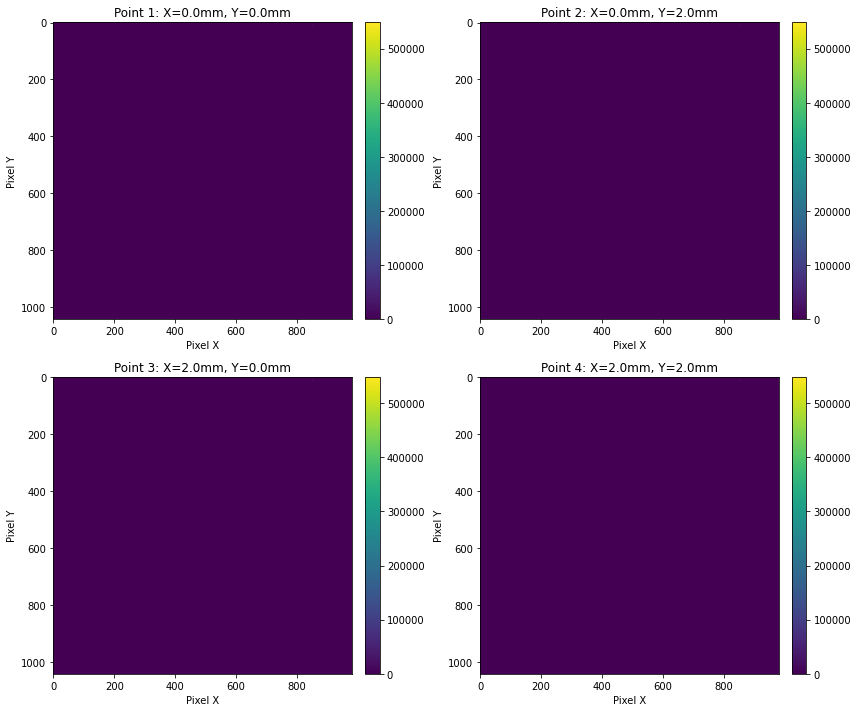

In [31]:
%matplotlib inline
# Display the 4 TIF images from the scan
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def display_scan_images(scan_data):
    """Display all TIF images from the scan in a 2x2 grid"""
    
    # Create 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # Make it easier to iterate
    
    print(f"📸 Displaying {len(scan_data)} images from the scan:")
    
    for i, data in enumerate(scan_data):
        if i >= 4:  # Only show first 4 images
            break
            
        file_path = data['full_path']
        
        try:
            # Load and display the image
            with Image.open(file_path) as img:
                img_array = np.array(img)
                
                # Calculate statistics
                total_counts = np.sum(img_array)
                max_val = np.max(img_array)
                min_val = np.min(img_array)
                mean_val = np.mean(img_array)
                std_val = np.std(img_array)

                # Display the image
                im = axes[i].imshow(img_array, cmap='viridis', aspect='auto')
                axes[i].set_title(f"Point {data['point']}: X={data['x_pos']:.1f}mm, Y={data['y_pos']:.1f}mm")
                axes[i].set_xlabel('Pixel X')
                axes[i].set_ylabel('Pixel Y')
                
                # Add colorbar
                plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
                
                print(f"  ✅ Point {data['point']}: {file_path}")

                print(f"Point {data['point']}:")
                print(f"  File: {file_path}")
                print(f"  Shape: {img_array.shape}")
                print(f"  Total counts: {total_counts:,.0f}")
                print(f"  Min/Max: {min_val:.0f} / {max_val:.0f}")
                print(f"  Mean ± Std: {mean_val:.2f} ± {std_val:.2f}")
                print(f"  Data type: {img_array.dtype}")
                print()
                
        except Exception as e:
            # Show error message on plot
            axes[i].text(0.5, 0.5, f"Error loading\nPoint {data['point']}\n{str(e)}", 
                        ha='center', va='center', transform=axes[i].transAxes,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))
            axes[i].set_title(f"Point {data['point']}: ERROR")
            print(f"  ❌ Point {data['point']}: Error - {e}")
    
    # Hide any unused subplots
    for j in range(len(scan_data), 4):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Display the images from the last scan
try:
    last_scan_data = file_callback.scan_data
    
    if last_scan_data:
        display_scan_images(last_scan_data)
    else:
        print("No scan data available. Please run a scan first!")
        
except NameError:
    print("file_callback not found. Please run the scan first!")
except Exception as e:
    print(f"Error displaying images: {e}")

In [32]:
RE(count([det], num=1), [live_table, file_callback])



📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 12:20:19.2 |                         |                                       |                       |                                     |
Point 1: /mnt/data531/20250630_alien005.tif
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
generator count ['b8c21c64'] (scan num: 12)


------------------------------------

('b8c21c64-7817-432d-91b4-a31e161b719a',)

📸 Taking a single count...
Reading file: /mnt/data531/20250630_alien005.tif
Image shape: (1043, 981)
Total counts: 1,022,717
Max value: 548413


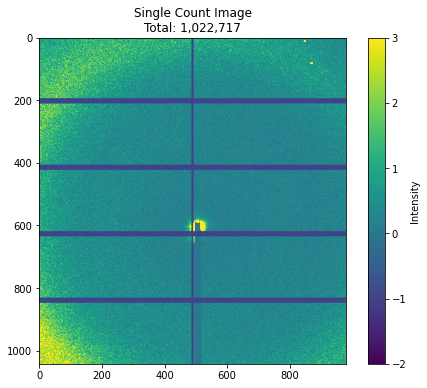

In [34]:
# Simple count and read TIF file
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Take a single count
print("📸 Taking a single count...")
RE(count([det], num=1))

# Get the last scan data from the file callback
last_scan_data = file_callback.scan_data

# Get the file path from the last point
file_path = last_scan_data[-1]['full_path']

print(f"Reading file: {file_path}")

# Load and display the image
with Image.open(file_path) as img:
    img_array = np.array(img)

# Show basic info
print(f"Image shape: {img_array.shape}")
print(f"Total counts: {np.sum(img_array):,.0f}")
print(f"Max value: {np.max(img_array)}")

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(img_array, cmap='viridis', vmax=np.percentile(img_array, 99))
plt.colorbar(label='Intensity')
plt.title(f'Single Count Image\nTotal: {np.sum(img_array):,.0f}')
plt.show()

In [36]:
# Get the (x,y) coordinate of the maximum value
max_index = np.argmax(img_array)
max_coords = np.unravel_index(max_index, img_array.shape)

print(f"Max index (flat): {max_index}")
print(f"Max coordinates (y,x): {max_coords}")
print(f"Max coordinates (x,y): ({max_coords[1]}, {max_coords[0]})")
print(f"Max value: {img_array[max_coords]}")

Max index (flat): 12622
Max coordinates (y,x): (12, 850)
Max coordinates (x,y): (850, 12)
Max value: 548413


### Pack up

The codes are working. Below I put things that are relavent and working, __from scratch__.


In [18]:
# Connect to Pilatus detector

import ophyd
import os
import numpy as np
from ophyd import ADComponent
from ophyd import ImagePlugin
from ophyd import PilatusDetector
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34
from ophyd import EpicsSignalRO

# File path configuration
PILATUS_FILES_ROOT = "/mnt/data531"
BLUESKY_FILES_ROOT = "/mnt/data531"
TEST_IMAGE_DIR = "test/pilatus/%Y/%m/%d/"

# Custom HDF5 plugin with file store integration
class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34): 
    pass

# Custom Pilatus detector class
class MyPilatusDetector(SingleTrigger, PilatusDetector):
    """Pilatus detector with HDF5 file writing capability"""
    image = ADComponent(ImagePlugin, "image1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=os.path.join(PILATUS_FILES_ROOT, TEST_IMAGE_DIR),
        read_path_template=os.path.join(BLUESKY_FILES_ROOT, TEST_IMAGE_DIR),
    )

# Create detector instance
det = MyPilatusDetector("13PIL1:", name="det")

# Configure detector settings
det.hdf1.create_directory.put(-5)                    # Auto-create directories
det.cam.stage_sigs["image_mode"] = "Single"
det.cam.stage_sigs["num_images"] = 1
det.cam.stage_sigs["acquire_time"] = 0.1             # 100ms exposure
det.cam.stage_sigs["acquire_period"] = 0.105         # 105ms period
det.hdf1.stage_sigs["lazy_open"] = 1
det.hdf1.stage_sigs["compression"] = "LZ4"
det.hdf1.stage_sigs["file_template"] = "%s%s_%3.3d.h5"
del det.hdf1.stage_sigs["capture"]                    # Remove default capture setting
det.hdf1.stage_sigs["capture"] = 1                    # Enable capture

# Print configuration summary
print("✅ Pilatus detector configured successfully!")
print(f"   PV prefix: 13PIL1:")
print(f"   File path: {PILATUS_FILES_ROOT}/{TEST_IMAGE_DIR}")
print(f"   Exposure time: {det.cam.stage_sigs['acquire_time']}s")

# Helper function to convert ASCII array to string
def ascii_array_to_string(ascii_array):
    """Convert ASCII character array to readable string"""
    try:
        if isinstance(ascii_array, (list, np.ndarray)):
            # Convert to numpy array and filter out null terminators and zeros
            arr = np.array(ascii_array)
            # Remove null terminators (0) and convert to characters
            chars = [chr(int(x)) for x in arr if x != 0 and x < 128]
            return ''.join(chars)
        else:
            return str(ascii_array)
    except:
        return str(ascii_array)

# Test file path and file information retrieval
print("\n🔍 Testing file path and file information access...")

# File information PVs for this detector (using actual prefix)
file_path_pv = '13PIL1:cam1:FilePath_RBV'          # Current file path
file_name_pv = '13PIL1:cam1:FileName_RBV'          # Current file name  
file_number_pv = '13PIL1:cam1:FileNumber_RBV'      # Current file number
file_template_pv = '13PIL1:cam1:FileTemplate_RBV'  # File naming template
full_filename_pv = '13PIL1:cam1:FullFileName_RBV'  # Complete file path+name
# For HDF5 plugin:
hdf5_filename_pv = '13PIL1:HDF1:FullFileName_RBV'  # HDF5 plugin file info

# Create EPICS signals to read these PVs
try:
    file_path_signal = EpicsSignalRO(file_path_pv, name='file_path')
    file_name_signal = EpicsSignalRO(file_name_pv, name='file_name')
    file_number_signal = EpicsSignalRO(file_number_pv, name='file_number')
    file_template_signal = EpicsSignalRO(file_template_pv, name='file_template')
    full_filename_signal = EpicsSignalRO(full_filename_pv, name='full_filename')
    hdf5_filename_signal = EpicsSignalRO(hdf5_filename_pv, name='hdf5_filename')
    
    # Wait for connections
    import time
    time.sleep(1)
    
    # Read and display current values (converted to strings)
    file_path_raw = file_path_signal.get()
    file_name_raw = file_name_signal.get()
    file_template_raw = file_template_signal.get()
    full_filename_raw = full_filename_signal.get()
    hdf5_filename_raw = hdf5_filename_signal.get()
    
    print(f"📁 Current file path: '{ascii_array_to_string(file_path_raw)}'")
    print(f"📄 Current file name: '{ascii_array_to_string(file_name_raw)}'")
    print(f"🔢 Current file number: {file_number_signal.get()}")
    print(f"📝 File template: '{ascii_array_to_string(file_template_raw)}'")
    print(f"🗂️  Full filename (cam): '{ascii_array_to_string(full_filename_raw)}'")
    print(f"🗂️  Full filename (HDF5): '{ascii_array_to_string(hdf5_filename_raw)}'")
    
    # Also check if we can access through the detector object
    print(f"\n📋 Via detector object:")
    if hasattr(det.cam, 'file_path'):
        print(f"   File path: {det.cam.file_path.get()}")
    if hasattr(det.cam, 'file_name'):
        print(f"   File name: {det.cam.file_name.get()}")
    if hasattr(det.hdf1, 'file_path'):
        print(f"   HDF5 file path: {det.hdf1.file_path.get()}")
    if hasattr(det.hdf1, 'file_name'):
        print(f"   HDF5 file name: {det.hdf1.file_name.get()}")
        
    # Decode the information we got
    print(f"\n🔍 Decoded information:")
    current_path = ascii_array_to_string(file_path_raw)
    current_name = ascii_array_to_string(file_name_raw)
    current_template = ascii_array_to_string(file_template_raw)
    current_full = ascii_array_to_string(full_filename_raw)
    
    print(f"   Camera is currently set to save files at: {current_path}")
    print(f"   Base filename: {current_name}")
    print(f"   Template: {current_template}")
    print(f"   Next file will be: {current_full}")
        
except Exception as e:
    print(f"❌ Error accessing file information: {e}")
    print("   This might be normal if the detector is not connected or PV names are different")

print("\n✅ File information test completed!")

✅ Pilatus detector configured successfully!
   PV prefix: 13PIL1:
   File path: /mnt/data531/test/pilatus/%Y/%m/%d/
   Exposure time: 0.1s

🔍 Testing file path and file information access...
📁 Current file path: '/mnt/data531/'
📄 Current file name: '20250630_alien'
🔢 Current file number: 17
📝 File template: '%s%s%03i.tif'
🗂️  Full filename (cam): '/mnt/data531/20250630_alien016.tif'
🗂️  Full filename (HDF5): ''

📋 Via detector object:
   HDF5 file path: /mnt/data531/test/pilatus/2025/06/30/
   HDF5 file name: 8a70d94b-a0b9-4375-8761

🔍 Decoded information:
   Camera is currently set to save files at: /mnt/data531/
   Base filename: 20250630_alien
   Template: %s%s%03i.tif
   Next file will be: /mnt/data531/20250630_alien016.tif

✅ File information test completed!


### Further editing

We inplemented the setup parts we coded earlier to the Set Up section. 

In [16]:
"""
SIMPLE COUNT TEST
================
Take a single count and check file generation.
"""

print("📸 Taking a simple count...")

# Check file info BEFORE count
file_path_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FilePath_RBV')
file_name_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileName_RBV')
file_number_signal = EpicsSignalRO(f'{DETECTOR_PREFIX}cam1:FileNumber_RBV')

before_count = file_number_signal.get()
file_path = ascii_array_to_string(file_path_signal.get())
file_name = ascii_array_to_string(file_name_signal.get())

print(f"BEFORE count:")
print(f"   File number: {before_count}")
print(f"   Expected file: {file_path}{file_name}{before_count:03d}.tif")

# Take the count
RE(count([det], num=1))

# Check file info AFTER count
time.sleep(2)  # Wait for file to be written
after_count = file_number_signal.get()

print(f"\nAFTER count:")
print(f"   File number: {after_count}")
print(f"   Expected file: {file_path}{file_name}{before_count:03d}.tif")

# Check if file actually exists
expected_file = f"{file_path}{file_name}{before_count:03d}.tif"
print(f"\nFile check:")
print(f"   Looking for: {expected_file}")
print(f"   File exists: {os.path.exists(expected_file)}")

# List recent files in directory
try:
    import glob
    recent_files = glob.glob(f"{file_path}*")[-10:]  # Last 10 files
    print(f"   Recent files in {file_path}:")
    for f in recent_files:
        print(f"      {f}")
except Exception as e:
    print(f"   Error listing files: {e}")

📸 Taking a simple count...
BEFORE count:
   File number: 17
   Expected file: /mnt/data531/20250630_alien017.tif

AFTER count:
   File number: 18
   Expected file: /mnt/data531/20250630_alien017.tif

File check:
   Looking for: /mnt/data531/20250630_alien017.tif
   File exists: False
   Recent files in /mnt/data531/:
      /mnt/data531/20250626_alien687.tif
      /mnt/data531/20250626_alien688.tif
      /mnt/data531/20250626_alien689.tif
      /mnt/data531/20250630_alien001.tif
      /mnt/data531/20250630_alien002.tif
      /mnt/data531/20250630_alien003.tif
      /mnt/data531/20250630_alien004.tif
      /mnt/data531/20250630_alien005.tif
      /mnt/data531/20250630_alien006.tif
      /mnt/data531/20250630_alien007.tif


In [11]:
"""
DETECTOR FILE SETTINGS CHECK
===========================
Check all file-related settings and try to sync the file counter.
"""

print("🔍 Checking detector file settings...")

# Check all file-related PVs
file_path_pv = f'{DETECTOR_PREFIX}cam1:FilePath_RBV'
file_name_pv = f'{DETECTOR_PREFIX}cam1:FileName_RBV'
file_number_pv = f'{DETECTOR_PREFIX}cam1:FileNumber_RBV'
file_template_pv = f'{DETECTOR_PREFIX}cam1:FileTemplate_RBV'
auto_save_pv = f'{DETECTOR_PREFIX}cam1:AutoSave_RBV'
auto_increment_pv = f'{DETECTOR_PREFIX}cam1:AutoIncrement_RBV'

signals = {
    'file_path': EpicsSignalRO(file_path_pv),
    'file_name': EpicsSignalRO(file_name_pv),
    'file_number': EpicsSignalRO(file_number_pv),
    'file_template': EpicsSignalRO(file_template_pv),
    'auto_save': EpicsSignalRO(auto_save_pv),
    'auto_increment': EpicsSignalRO(auto_increment_pv),
}

time.sleep(1)

print("Current settings:")
for name, signal in signals.items():
    try:
        value = signal.get()
        if name in ['file_path', 'file_name', 'file_template']:
            value = ascii_array_to_string(value)
        print(f"   {name}: {value}")
    except Exception as e:
        print(f"   {name}: Error - {e}")

# Try to reset file number to match actual files
print(f"\n🔧 Attempting to sync file counter...")
try:
    # Set file number to 8 (next after alien007.tif)
    file_number_set_pv = f'{DETECTOR_PREFIX}cam1:FileNumber'
    epics.caput(file_number_set_pv, 8)
    time.sleep(1)
    
    new_file_number = epics.caget(file_number_pv)
    print(f"   File number reset to: {new_file_number}")
    
    # Try another count
    print(f"\n📸 Trying count with synced file number...")
    RE(count([det], num=1))
    
    time.sleep(2)
    expected_file = f"/mnt/data531/20250630_alien008.tif"
    print(f"   Expected file: {expected_file}")
    print(f"   File exists: {os.path.exists(expected_file)}")
    
except Exception as e:
    print(f"   Error resetting file number: {e}")

🔍 Checking detector file settings...
Current settings:
   file_path: /mnt/data531/
   file_name: 20250630_alien
   file_number: 43
   file_template: %s%s%03i.tif
   auto_save: 0
   auto_increment: 1

🔧 Attempting to sync file counter...
   File number reset to: 8

📸 Trying count with synced file number...
   Expected file: /mnt/data531/20250630_alien008.tif
   File exists: False


In [12]:
"""
FIX DETECTOR FILE SAVING
========================
Enable auto_save to actually write files to disk.
"""

print("🔧 Enabling detector file saving...")

# Enable auto save
auto_save_pv = f'{DETECTOR_PREFIX}cam1:AutoSave'
print(f"Setting AutoSave to 1...")
epics.caput(auto_save_pv, 1)

time.sleep(2)

# Verify settings
auto_save_check = epics.caget(f'{DETECTOR_PREFIX}cam1:AutoSave_RBV')
auto_increment_check = epics.caget(f'{DETECTOR_PREFIX}cam1:AutoIncrement_RBV')

print(f"AutoSave now: {auto_save_check}")
print(f"AutoIncrement: {auto_increment_check}")

if auto_save_check == 1:
    print("✅ AutoSave enabled!")
    
    # Try a quick count
    print("\n📸 Testing with AutoSave enabled...")
    start_time = time.time()
    
    RE(count([det], num=1))
    
    end_time = time.time()
    print(f"Count took: {end_time - start_time:.1f} seconds")
    
    # Check if file was created
    time.sleep(1)
    current_file_num = epics.caget(f'{DETECTOR_PREFIX}cam1:FileNumber_RBV') - 1
    expected_file = f"/mnt/data531/20250630_alien{current_file_num:03d}.tif"
    
    print(f"Expected file: {expected_file}")
    print(f"File exists: {os.path.exists(expected_file)}")
    
else:
    print("❌ Failed to enable AutoSave")

🔧 Enabling detector file saving...
Setting AutoSave to 1...
AutoSave now: 1
AutoIncrement: 1
✅ AutoSave enabled!

📸 Testing with AutoSave enabled...
Count took: 87.8 seconds
Expected file: /mnt/data531/20250630_alien009.tif
File exists: False


In [13]:
"""
DETECTOR STATUS DIAGNOSIS
========================
Check what the detector is actually doing during acquisition.
"""

print("🔍 Checking detector acquisition status...")

# Check detector state and acquisition settings
status_pvs = {
    'detector_state': f'{DETECTOR_PREFIX}cam1:DetectorState_RBV',
    'acquire': f'{DETECTOR_PREFIX}cam1:Acquire_RBV',
    'acquire_time': f'{DETECTOR_PREFIX}cam1:AcquireTime_RBV',
    'acquire_period': f'{DETECTOR_PREFIX}cam1:AcquirePeriod_RBV',
    'num_images': f'{DETECTOR_PREFIX}cam1:NumImages_RBV',
    'image_mode': f'{DETECTOR_PREFIX}cam1:ImageMode_RBV',
    'trigger_mode': f'{DETECTOR_PREFIX}cam1:TriggerMode_RBV',
    'armed': f'{DETECTOR_PREFIX}cam1:Armed_RBV',
}

print("Current detector status:")
for name, pv in status_pvs.items():
    try:
        value = epics.caget(pv)
        if name in ['detector_state', 'image_mode', 'trigger_mode']:
            # These are enum values, try to get string representation
            try:
                str_value = epics.caget(pv + '_STR')
                print(f"   {name}: {value} ({str_value})")
            except:
                print(f"   {name}: {value}")
        else:
            print(f"   {name}: {value}")
    except Exception as e:
        print(f"   {name}: Error - {e}")

# Check if there are any error messages
print(f"\nChecking for errors...")
try:
    status_message = epics.caget(f'{DETECTOR_PREFIX}cam1:StatusMessage_RBV')
    if status_message:
        status_str = ascii_array_to_string(status_message)
        print(f"   Status message: {status_str}")
    else:
        print("   No status message")
except:
    print("   Could not read status message")

# Try a very short exposure test
print(f"\n📸 Testing with 0.01s exposure...")
det.cam.stage_sigs["acquire_time"] = 0.01
det.cam.stage_sigs["acquire_period"] = 0.02

start_time = time.time()
RE(count([det], num=1))
end_time = time.time()

print(f"Short exposure count took: {end_time - start_time:.1f} seconds")

🔍 Checking detector acquisition status...
Current detector status:
cannot connect to 13PIL1:cam1:DetectorState_RBV_STR
   detector_state: 6 (None)
   acquire: 0
   acquire_time: 1.5
   acquire_period: 1.0
   num_images: 1
cannot connect to 13PIL1:cam1:ImageMode_RBV_STR
   image_mode: 0 (None)
cannot connect to 13PIL1:cam1:TriggerMode_RBV_STR
   trigger_mode: 0 (None)
cannot connect to 13PIL1:cam1:Armed_RBV
   armed: None

Checking for errors...
   Could not read status message

📸 Testing with 0.01s exposure...
Short exposure count took: 86.7 seconds


In [15]:
"""
DIRECT DETECTOR CONTROL TEST
===========================
Try controlling the detector directly via EPICS without Bluesky.
"""

print("🔧 Testing direct detector control...")

# Try to set exposure time directly
print("Setting exposure time directly...")
try:
    epics.caput(f'{DETECTOR_PREFIX}cam1:AcquireTime', 0.1)
    time.sleep(1)
    actual_time = epics.caget(f'{DETECTOR_PREFIX}cam1:AcquireTime_RBV')
    print(f"   Set: 0.1s, Actual: {actual_time}s")
except Exception as e:
    print(f"   Error setting exposure: {e}")

# Check if detector is responsive
print(f"\nTesting basic detector communication...")
try:
    # Try to read a simple PV
    manufacturer = epics.caget(f'{DETECTOR_PREFIX}cam1:Manufacturer_RBV')
    if manufacturer:
        print(f"   Manufacturer: {ascii_array_to_string(manufacturer)}")
    
    model = epics.caget(f'{DETECTOR_PREFIX}cam1:Model_RBV')
    if model:
        print(f"   Model: {ascii_array_to_string(model)}")
        
    print("   ✅ Basic communication working")
    
except Exception as e:
    print(f"   ❌ Communication error: {e}")

# Try manual acquire
print(f"\n📸 Testing manual acquire...")
try:
    print("   Starting manual acquisition...")
    start_time = time.time()
    
    # Start acquisition
    epics.caput(f'{DETECTOR_PREFIX}cam1:Acquire', 1)
    
    # Wait for completion (with timeout)
    timeout = 10  # 10 second timeout
    elapsed = 0
    while elapsed < timeout:
        acquire_status = epics.caget(f'{DETECTOR_PREFIX}cam1:Acquire_RBV')
        if acquire_status == 0:  # Acquisition finished
            break
        time.sleep(0.1)
        elapsed += 0.1
    
    end_time = time.time()
    print(f"   Manual acquire took: {end_time - start_time:.1f} seconds")
    
    if elapsed >= timeout:
        print("   ⚠️  Acquisition timed out!")
        # Try to stop it
        epics.caput(f'{DETECTOR_PREFIX}cam1:Acquire', 0)
    else:
        print("   ✅ Manual acquisition completed")
        
except Exception as e:
    print(f"   ❌ Manual acquire error: {e}")

print(f"\n💡 Diagnosis:")
print(f"   The detector may have hardware/firmware issues")
print(f"   or the PV prefix '{DETECTOR_PREFIX}' might be incorrect")
print(f"   Consider checking with beamline staff")

🔧 Testing direct detector control...
Setting exposure time directly...
   Set: 0.1s, Actual: 0.1s

Testing basic detector communication...
   Manufacturer: Dectris
   Model: Pilatus
   ✅ Basic communication working

📸 Testing manual acquire...
   Starting manual acquisition...
   Manual acquire took: 0.0 seconds
   ✅ Manual acquisition completed

💡 Diagnosis:
   The detector may have hardware/firmware issues
   or the PV prefix '13PIL1:' might be incorrect
   Consider checking with beamline staff


In [11]:
# Use custom LiveTable and file callback with summary
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 4, 6, 2, sample_y_mm, 8, 10, 2, snake_axes=False), 
   [live_table, file_callback])


📸 Image Files:
--------------------------------------------------------------------------------


+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|   seq_num |       time | sample stage horizontal | sample stage horizontal_user_setpoint | sample stage vertical | sample stage vertical_user_setpoint |
+-----------+------------+-------------------------+---------------------------------------+-----------------------+-------------------------------------+
|         1 | 15:53:09.7 |                  4.0000 |                                       |                8.0000 |                                     |
Point 1: /mnt/data531/20250630_alien030.tif
|         2 | 15:53:27.9 |                  4.0000 |                                       |               10.0000 |                                     |
Point 2: /mnt/data531/20250630_alien031.tif
|         3 | 15:53:46.3 |            

('c70bedd9-57a5-4fab-a2ff-7eec4d914872',)

In [17]:
# Display the scan images in a grid

# Get scan data
last_scan_data = file_callback.scan_data

# Get unique motor positions
x_positions = [point['x_pos'] for point in last_scan_data]
y_positions = [point['y_pos'] for point in last_scan_data]

unique_x = sorted(list(set(x_positions)))
unique_y = sorted(list(set(y_positions)))

num_x = len(unique_x)
num_y = len(unique_y)

print(f"Grid: {num_x}×{num_y} positions")

# Create subplot grid
fig, axes = plt.subplots(num_y, num_x, figsize=(3*num_x, 3*num_y))

# Handle single row/column cases
if num_x == 1 and num_y == 1:
    axes = [[axes]]
elif num_x == 1:
    axes = [[ax] for ax in axes]
elif num_y == 1:
    axes = [axes]

# Load and plot each image
for point in last_scan_data:
    x_idx = unique_x.index(point['x_pos'])
    y_idx = unique_y.index(point['y_pos'])
    
    # Load image
    with Image.open(point['full_path']) as img:
        img_array = np.array(img)
    
    # Plot image
    im = axes[y_idx][x_idx].imshow(img_array, cmap='viridis',
                                   vmin=np.percentile(img_array, 2),
                                   vmax=np.percentile(img_array, 98))
    
    axes[y_idx][x_idx].set_title(f'X={point["x_pos"]:.1f}, Y={point["y_pos"]:.1f}', fontsize=10)
    axes[y_idx][x_idx].axis('off')
    
    plt.colorbar(im, ax=axes[y_idx][x_idx], shrink=0.6)

# Add main title
plt.suptitle(f'Scan Grid: {num_x}×{num_y} positions', fontsize=12, y=0.98)
plt.tight_layout()
plt.show()

Grid: 3×3 positions


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data531/20250630_alien008.tif'

In [ ]:
# Use custom LiveTable and file callback with summary
live_table = LiveTableWithPoint([det, sample_x_mm, sample_y_mm])
file_callback = FilePathCallback()

# Run scan with both callbacks
RE(grid_scan([det], sample_x_mm, 3, 7, 3, sample_y_mm, 6, 10, 3, snake_axes=True), 
   [live_table, file_callback])